In [ ]:
! python -m pip install --upgrade pip
! python -m pip install scikit-learn-intelex
! pip install optuna
! pip install imbalanced-learn

In [1]:
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder , LabelEncoder , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay , f1_score ,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV

In [4]:
df=pd.read_csv('train1.csv')
cat=df.select_dtypes(include=np.object_).columns.tolist()
categorical_transformer = Pipeline(
    steps=[(
    "encoder",OrdinalEncoder()
    )]
)
categorical_transformer.fit_transform(df[cat])
cat_frame=pd.DataFrame(data=categorical_transformer.fit_transform(df[cat]), columns=df[cat].columns)
df[cat]=cat_frame[cat]
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)
num_frame=pd.DataFrame(data=numeric_transformer.fit_transform(df), columns=df.columns)

In [5]:
features=df.columns[:-1]
target=df.columns[-1]
features=['offer_expiration(hrs)',
          'drop_location',
          'temperature',
          # 'children',
          # 'age',
          # # 'gender'
          ]
X=num_frame[features]
y=num_frame[target]
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, 
    test_size=0.20,
    random_state=42,
    shuffle=True
)
X_train_1, X_val, y_train_1, y_val = train_test_split(
    X_train, y_train,
     test_size=0.15,
      random_state=12,
      shuffle=True
)

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate

In [7]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [8]:
def objective(trial):
    params ={
        'C': trial.suggest_float('C', 0.000000001, 1000.0),
        'solver' : trial.suggest_categorical("solver", ("lbfgs", "saga","liblinear","sag")),
        'random_state': 0,
        'n_jobs': -1,
        'class_weight':"balanced",
    }
    model = LogisticRegression(**params)
    scoring = ["balanced_accuracy"]
    cv_result = cross_validate(model, X_train, y_train, cv=10, scoring=scoring)
    score=cv_result['test_balanced_accuracy'].mean()
    return score

In [9]:
import optuna 
from timeit import default_timer as timer

In [10]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123),
                            direction="maximize",
                            pruner=optuna.pruners.HyperbandPruner())

[I 2022-09-28 20:20:52,047] A new study created in memory with name: no-name-707394de-4ede-467c-82b1-268785070ded


In [ ]:
start = timer()
study.optimize(objective, n_trials=200)
select_params_opt = timer() - start
f"Intel® extension for Scikit-learn selection time: {select_params_opt:.2f} s"

In [12]:
print(f"Best Value from optune: {study.best_trial.value}")
print(f"Best Params from optune: {study.best_params}")

Best Value from optune: 0.5421920108146867
Best Params from optune: {'C': 696.4691855981652, 'solver': 'sag'}


In [13]:
start = timer()
final_model = LogisticRegression(**study.best_params, random_state=0, n_jobs=-1).fit(X_train, y_train)
train_opt = timer() - start
f"Intel® extension for Scikit-learn train final model time: {train_opt:.2f} s"

'Intel® extension for Scikit-learn train final model time: 0.07 s'

In [14]:
l=[]
t=final_model.coef_
for x,y in zip(X_train.columns,t[0]):
  l.append((abs(y),x))
l.sort(reverse=True)
for x in l:
  print(x)

(0.3032259130540131, 'drop_location')
(0.2731324082524873, 'offer_expiration(hrs)')
(0.2126870283207691, 'temperature')


In [15]:
y_pred=final_model.predict(X_train)
p=classification_report(y_train,y_pred)
print(p)

              precision    recall  f1-score   support

         0.0       0.54      0.12      0.20      4280
         1.0       0.58      0.92      0.71      5623

    accuracy                           0.58      9903
   macro avg       0.56      0.52      0.46      9903
weighted avg       0.56      0.58      0.49      9903



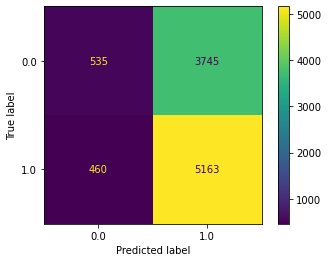

In [16]:
disp=ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred, labels=final_model.classes_),display_labels=final_model.classes_)
disp.plot()

In [17]:
y_pred=final_model.predict(X_test)
p=classification_report(y_test,y_pred)
print(p)

              precision    recall  f1-score   support

         0.0       0.58      0.13      0.22      1105
         1.0       0.57      0.92      0.70      1371

    accuracy                           0.57      2476
   macro avg       0.57      0.53      0.46      2476
weighted avg       0.57      0.57      0.49      2476



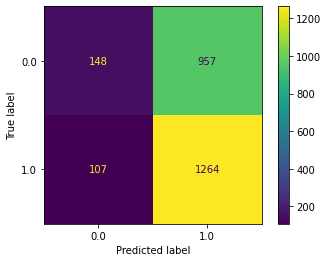

In [18]:
disp=ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=final_model.classes_),display_labels=final_model.classes_)
disp.plot()

In [19]:
df=pd.read_csv('test1.csv')
cat=df.select_dtypes(include=np.object_).columns.tolist()
categorical_transformer = Pipeline(
    steps=[(
    "encoder",OrdinalEncoder()
    )]
)
categorical_transformer.fit_transform(df[cat])
cat_frame=pd.DataFrame(data=categorical_transformer.fit_transform(df[cat]), columns=df[cat].columns)
df[cat]=cat_frame[cat]
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)
num_frame=pd.DataFrame(data=numeric_transformer.fit_transform(df), columns=df.columns)

In [22]:
features=['offer_expiration(hrs)',
          'drop_location',
          'temperature',
          # 'children',
          # 'age',
          # 'gender'
          ]
X=num_frame[features]

In [23]:
y_sample_pred = final_model.predict(X)
result=[]
for x in y_sample_pred:
    if(x==1):
        result.append('Yes')
    else:
        result.append('No')
submission=pd.DataFrame(columns=['id','Offer Accepted'])
submission['id']=[i for i in range(len(y_sample_pred))]
submission['Offer Accepted']=result

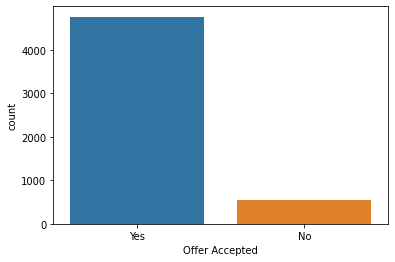

In [24]:
sns.countplot(x=submission['Offer Accepted'])

In [25]:
submission.to_csv('submission.csv',index=False)